In [259]:
import numpy as np
from numpy import genfromtxt
from numpy import random
import matplotlib as mpl
import matplotlib.gridspec
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy as sp
import sympy
from scipy.integrate import quad, dblquad, tplquad, simpson
from scipy import interpolate
#! /usr/bin/env python
# import lhapdf
from parton import mkPDF
import mcint
import vegas
import pandas as pd
from tqdm.notebook import tqdm
from scipy.optimize import minimize

## My imports
from WIC_Pheno_Formulae import *

# Import LHE

In [260]:
## Import ##
MC_Events_LHE = []; temp_event = []; x = 0
file = open("MC_Events.mylhe",'r').read().splitlines()
for line in file: 
    particle = line.strip().split()
    ### If we're at the 1st particle, increment x
    if particle[0] == 'PID1': x = x + 1
    ### If we encounter a particle (within the same event), append temp_event
    if len(particle) == 9 and x!=2:  
        temp_event.append(particle)
    ### If we encounter a particle in the next event, append MC_Events_LHE and reset temp_event, x
    if x==2:  
        MC_Events_LHE.append(temp_event)
        temp_event = []
        temp_event.append(particle)
        x = 1

## Convert to Floats ## 
MC_Events_LHE_new = [] 
for event in MC_Events_LHE: 
    temp_event = []
    for particle in event:
        new_particle = list(map(float, particle[1:]))
        temp_event.append( [particle[0]] + new_particle )
    MC_Events_LHE_new.append(temp_event)
MC_Events_LHE = MC_Events_LHE_new

In [261]:
def θ(X):
    x = X[0]; y = X[1]; z = X[2]
    return np.arctan(np.sqrt(x**2 + y**2)/z)
def η(θ):
    return -np.log(np.tan(θ/2))
def φ(X):
    x = X[0]; y = X[1]; z = X[2]
    if x>0          : return np.arctan(y/x)
    if x<0  and y>=0: return np.arctan(y/x) + np.pi
    if x<0  and y <0: return np.arctan(y/x) - np.pi
    if x==0 and y >0: return np.pi/2
    if x==0 and y <0: return -np.pi/2

# Loop for all kinematics

In [262]:
## Extract Kinematics from MC_Events_LHE
multiplicities = []; obs_mult = [];
electrons = []; muons = []; taus = [];
eNeutrinos = []; muNeutrinos = []; tauNeutrinos = []; Neutrinos = [];
jets = [];
μ1s   = []; μ2s   = []; μ3s   = []; μ4s   = []; μ5s  = []; 
μ1ps  = []; μ2ps  = []; μ3ps  = []; μ4ps  = []; μ5ps = []; 
v1s   = []; v2s   = []; v3s   = []; v4s   = []; v5s  = [];
v1ps  = []; v2ps  = []; v3ps  = []; v4ps  = []; v5ps = [];
d1s = []; d2s = []; d3s = []; d4s = []; d5s = [];
d1ps = []; d2ps = []; d3ps = []; d4ps = []; d5ps = [];
max_ds = []; minFermionE = []; maxFermionE = []; ProdFermionE = []; max_d_ID = [];
Mff2  = []; Mff3  = []; Mff4  = []; Mff5  = [];
Mff2p = []; Mff3p = []; Mff4p = []; Mff5p = [];
θff2  = []; θff3  = []; θff4  = []; θff5  = [];
θffij = [];
ΔR = [];
MET = [];
# C = []; Thrust = []; Spherocity = []
#
max_fE = [];
#
Total_xMomentum = []; Total_yMomentum = []; Total_zMomentum = []; Total_Energy = [];
Total_InvMass = []; Total_InvMass_prime = []; fermion_energies = []; 
max1_fermion_energies = []; max2_fermion_energies = []; max3_fermion_energies = [];
max4_fermion_energies = []; max5_fermion_energies = []; max6_fermion_energies = [];
max7_fermion_energies = []; max8_fermion_energies = []; max9_fermion_energies = [];
max10_fermion_energies = []; max11_fermion_energies = []; max12_fermion_energies = [];
max13_fermion_energies = []; max14_fermion_energies = [];
def MassVelVer(pIndex, ID, step):
    if p[0] == ID:
        if ID[-1]!='p':
            eval('μ' + str(step) + 's').append(event[pIndex][2])
            eval('v' + str(step) + 's').append(v)
            if p[8] != np.inf:
                eval('d' + str(step) + 's').append(v*event[pIndex][8])
                max_d_temp.append(v*event[pIndex][8])
                max_d_ID_temp.append(ID)
                if step==1: 
                    eval('f' + str(step+1) + 'aEs').append(event[pIndex+2][3])  ## + 2
                    eval('f' + str(step+1) + 'bEs').append(event[pIndex+3][3])  ## + 3
                if step!=1: 
                    eval('f' + str(step+1) + 'aEs').append(event[pIndex+4][3])  ## + 4
                    eval('f' + str(step+1) + 'bEs').append(event[pIndex+5][3])  ## + 5
        if ID[-1]=='p':
            eval('μ' + str(step) + 'ps').append(p[2])
            eval('v' + str(step) + 'ps').append(v)
            if p[8] != np.inf:
                eval('d' + str(step) + 'ps').append(v*p[8])
                max_d_p_temp.append(v*p[8])
                max_d_p_ID_temp.append(ID)
                if step==1: 
                    eval('f' + str(step+1) + 'apEs').append(event[pIndex+2][3])
                    eval('f' + str(step+1) + 'bpEs').append(event[pIndex+3][3])
                if step!=1: 
                    eval('f' + str(step+1) + 'apEs').append(event[pIndex+4][3])
                    eval('f' + str(step+1) + 'bpEs').append(event[pIndex+5][3])
c=3*10**8 # m/s 

## (incrementing the i^th event 'event' ) ##
for i, event in enumerate(MC_Events_LHE):
    Px = 0; Py = 0; Pz = 0; E = 0;
    pxMET = []; pyMET = [];
    e_count = 0;   μ_count = 0;   τ_count = 0;
    νe_count = 0;  νμ_count = 0;   ντ_count = 0;
    jet_count = 0; 
    obs_mult_count = 0;
    momenta = []; momenta_mags = []; pi_dot_n = []; pi_x_n = [];
    fermion_momenta = []; quark_momenta = [];
    max_d_temp = []; max_d_p_temp = [];
    max_d_ID_temp = []; max_d_p_ID_temp = [];
    f2aEs = [];  f3aEs = [];  f4aEs = [];  f5aEs = [];  f6aEs = [];
    f2apEs = []; f3apEs = []; f4apEs = []; f5apEs = []; f6apEs = []; 
    f2bEs = [];  f3bEs = [];  f4bEs = [];  f5bEs = [];  f6bEs = []; 
    f2bpEs = []; f3bpEs = []; f4bpEs = []; f5bpEs = []; f6bpEs = []; 
    ######################## Multiplicities  ########################
    multiplicities.append(len(event))
    #################################################################
    ## (incrementing the i^th particle 'p' ) ##
    for i, p in enumerate(event): 
        v=c*np.sqrt(p[4]**2 + p[5]**2 + p[6]**2)/p[3]
#         print('lifetime for particle ' + str(p[0]) + ' is ' + str(p[8]))
#         print('v*lifetime for particle ' + str(p[0]) + ' is ' + str(v*p[8]))
        ######################## Mass & Velocity & Dis. Vertex & Fermion E ######################## 
        MassVelVer(i, 'PID1', 1)
        MassVelVer(i, 'PID1p', 1)
        MassVelVer(i, 'PID2', 2)
        MassVelVer(i, 'PID2p', 2)
        MassVelVer(i, 'PID3', 3)
        MassVelVer(i, 'PID3p', 3)
        MassVelVer(i, 'PID4', 4)
        MassVelVer(i, 'PID4p', 4)
        MassVelVer(i, 'PID5', 5)
        MassVelVer(i, 'PID5p', 5)
        ###################################################################
        ##################### No. e's, mu's, jets, etc ####################
        if np.abs(p[1]) == 11: e_count += 1
        if np.abs(p[1]) == 13: μ_count += 1
        if np.abs(p[1]) == 15: τ_count += 1
        if np.abs(p[1]) == 12: νe_count += 1
        if np.abs(p[1]) == 14: νμ_count += 1
        if np.abs(p[1]) == 16: ντ_count += 1 
        if 1 <= np.abs(p[1]) <= 5: jet_count +=1
        ########## No. Observable Particles, Fermion Momenta & Energies ##########
        if p[1] != 1000000: 
            obs_mult_count += 1
            fermion_momenta.append([p[3],p[4],p[5],p[6]])
            fermion_energies.append(p[3])
        ##################### Ferimon Pair Inv Mass, Angles ########################
        if p[0][-1]=='a' or p[0][-2]=='a' :    ## if it's the first fermion in the pair
            fa=event[i][1:]; fb=event[i+1][1:]
            paDOTpb = fa[3]*fb[3] + fa[4]*fb[4] + fa[5]*fb[5]
            pa_mag = np.sqrt(fa[3]**2 + fa[4]**2 + fa[5]**2)
            pb_mag = np.sqrt(fb[3]**2 + fb[4]**2 + fb[5]**2)
        if p[0] == 'PID2a' :
            Mff2.append( np.sqrt(2*(fa[2]*fb[2] - paDOTpb)) )  
            θff2.append(paDOTpb / (pa_mag*pb_mag))
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID3a' : 
            Mff3.append( np.sqrt(2*(fa[2]*fb[2] - paDOTpb)) ) 
            θff3.append(paDOTpb / (pa_mag*pb_mag))
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID4a' :
            Mff4.append( np.sqrt(2*(fa[2]*fb[2] - paDOTpb)) ) 
            θff4.append(paDOTpb / (pa_mag*pb_mag))
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID5a' :
            Mff5.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
            if 1 <= np.abs(p[1]) <= 5: 
                quark_momenta.append([fa[3],fa[4],fa[5]])
                quark_momenta.append([fb[3],fb[4],fb[5]])
        if p[0] == 'PID2ap' :
            Mff2p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
        if p[0] == 'PID3ap' : 
            Mff3p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) )
        if p[0] == 'PID4ap' : 
            Mff4p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
        if p[0] == 'PID5ap' : 
            Mff5p.append( np.sqrt(2*(fa[2]*fb[2] - fa[3]*fb[3] - fa[4]*fb[4] - fa[5]*fb[5])) ) 
        ################################## MET ###########################################
        if p[1] == 1000000 and p[7] == 0:
            pxMET.append(p[4])
            pyMET.append(p[5])
        #################### Check Momentum & Energy Conservation ########################
        if p[7] == 0: 
            Px = Px + p[4]; Py = Py + p[5]; Pz = Pz + p[6]; E  = E  + p[3]
##############################################################################################################
# ##################### Maximum Displaced Vertex ###########################
#     if len(max_d_temp)>0 or len(max_d_p_temp)>0: 
#     if len(max_d_temp)>0: max_ds.append(np.max(max_d_temp))
##################### Max Displaced Vertex & Corresponding (min) Fermion Energy  ##########################
    if len(max_d_temp)>0 or len(max_d_p_temp)>0: 
        max_d = 0 
        max_d_p = 0 
        if   len(max_d_temp)>0:  max_d = np.max(max_d_temp)
        if len(max_d_p_temp)>0:  max_d_p = np.max(max_d_p_temp)
        if max_d > max_d_p:
            max_ds.append(max_d)
            d_max_index = np.where(max_d_temp==max_d)[0][0]
            fermionpairWmaxD = [eval('f' + str(d_max_index+2) + 'aEs'), eval('f' + str(d_max_index+2) + 'bEs')]
            max_d_ID.append(max_d_ID_temp[d_max_index])
        if max_d < max_d_p:
            max_ds.append(max_d_p)
            d_max_index = np.where(max_d_p_temp==max_d_p)[0][0]
            fermionpairWmaxD = [eval('f' + str(d_max_index+2) + 'apEs'), eval('f' + str(d_max_index+2) + 'bpEs')]
            max_d_ID.append(max_d_p_ID_temp[d_max_index])
        minFermionE.append(np.min(fermionpairWmaxD))
        maxFermionE.append(np.max(fermionpairWmaxD))
        ProdFermionE.append(np.min(fermionpairWmaxD)*np.max(fermionpairWmaxD))
##################### No. e's, mu's, jets, etc ###########################
    electrons.append(e_count)
    muons.append(μ_count)
    taus.append(τ_count)
    Neutrinos.append(νe_count + νμ_count + ντ_count)
#     muNeutrinos.append(νμ_count)
#     tauNeutrinos.append(ντ_count)
    jets.append(jet_count)
    obs_mult.append(obs_mult_count)
################################### MET ##################################
    MET.append(np.sqrt(sum(pxMET)**2 + sum(pyMET)**2))
######################### Max Fermion Energies ###########################
    if len(fermion_momenta) > 1:
        max1_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-1])
        max2_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-2])
    if len(fermion_momenta) > 2:
        max3_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-3])
    if len(fermion_momenta) > 3:
        max4_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-4])
    if len(fermion_momenta) > 4:
        max5_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-5])
    if len(fermion_momenta) > 5:
        max6_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-6])
    if len(fermion_momenta) > 6:
        max7_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-7])
    if len(fermion_momenta) > 7:
        max8_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-8])
    if len(fermion_momenta) > 8:
        max9_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-9])
    if len(fermion_momenta) > 9:
        max10_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-10])
    if len(fermion_momenta) > 10:
        max11_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-11])
    if len(fermion_momenta) > 11:
        max12_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-12])
    if len(fermion_momenta) > 12:
        max13_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-13])
    if len(fermion_momenta) > 13:
        max14_fermion_energies.append(np.sort(np.transpose(np.array(fermion_momenta))[0])[-14])
##################### Angles Between Fermion Pairs #######################
    for m, fp1 in enumerate(fermion_momenta):
        for n, fp2 in enumerate(fermion_momenta):
            if m > n: 
                θffij.append((fp1[1]*fp2[1] + fp1[2]*fp2[2] + fp1[3]*fp2[3]) /\
                             (np.sqrt(fp1[1]**2 + fp1[2]**2 + fp1[3]**2)*\
                              np.sqrt(fp2[1]**2 + fp2[2]**2 + fp2[3]**2)))
############################ ΔR of quarks ################################
    for m, qp1 in enumerate(quark_momenta):
        for n, qp2 in enumerate(quark_momenta):
            if m < n: 
                ΔR.append(np.sqrt( (η(θ(qp1)) - η(θ(qp2)))**2 + (φ(qp1) - φ(qp2))**2) )
##################### Momentum Conservation check ########################
    Total_xMomentum.append(Px)
    Total_yMomentum.append(Py)
    Total_zMomentum.append(Pz)
    Total_Energy.append(E)
    ########################  Inv Mass of Entire Event  ######################## 
    Es = []; pxs = []; pys = []; pzs = []
    Eps = []; ppxs = []; ppys = []; ppzs = []
    p = 0
    while True:
        particle = event[p]
        if particle[0] == 'PID1p': break
        p = p + 1
        if particle[7] == 0: 
            Es.append(particle[3])
            pxs.append(particle[4])
            pys.append(particle[5])
            pzs.append(particle[6])
    Total_InvMass.append(np.sqrt(sum(Es)**2 - sum(pxs)**2 - sum(pys)**2 - sum(pzs)**2))
    for k in range(p, len(event)):
        if event[k][7] == 0:
            Eps.append(event[k][3])
            ppxs.append(event[k][4])
            ppys.append(event[k][5])
            ppzs.append(event[k][6])
    Total_InvMass_prime.append(np.sqrt(sum(Eps)**2 - sum(ppxs)**2 - sum(ppys)**2 - sum(ppzs)**2))
    ################################################################################################
print('done!')

/var/folders/3b/1lt3qrpn635524qxcctqlg040000gn/T/ipykernel_40945/2905072860.py:5: RuntimeWarning: invalid value encountered in log
  return -np.log(np.tan(θ/2))


done!


# Loop for C-parameter, Thrust, Spherocity

In [164]:
C = []; Thrust = []; Spherocity = []
for i, event in enumerate(MC_Events_LHE):
    if i%5000==0: print(str(i) + ' of ' + str(len(MC_Events_LHE)))
    #################################################################################
    momenta = []; momenta_mags = []; pi_dot_n = []; pi_x_n = [];
    ###################### C-Parameter, Thrust, Spherocity ###########################
    for i, p in enumerate(event): 
        if p[7] == 0:
            momenta.append([p[4], p[5], p[6]])
            momenta_mags.append(np.sqrt(p[4]**2 + p[5]**2 + p[6]**2))
            angles = 'placeholder'
            def n(θ,φ): return [np.sin(θ)*np.cos(φ),np.sin(θ)*np.sin(φ),np.cos(θ)] 
            def p_dot_n_func(angles,p): 
                return lambda angles: np.abs(np.dot([p[4], p[5], p[6]], n(angles[0],angles[1])))
            def p_x_n_func(angles,p):
                return lambda angles: np.sqrt(np.cross([p[4], p[5], p[6]], n(angles[0],angles[1]))[0]**2 +\
                                              np.cross([p[4], p[5], p[6]], n(angles[0],angles[1]))[1]**2 +\
                                              np.cross([p[4], p[5], p[6]], n(angles[0],angles[1]))[2]**2)
            pi_dot_n.append(p_dot_n_func(angles,p))
            pi_x_n.append(p_x_n_func(angles,p))
    ###################################################################################     
    c1 = np.outer(momenta_mags, momenta_mags)
    c2 = np.matmul(momenta, np.array(momenta).transpose())
    C.append( (3/2)*np.sum(c1 - (c2**2)/c1)/(np.sum(momenta_mags)**2) )
    max_index = momenta_mags.index(max(momenta_mags))
    max_momenta = momenta[max_index]
    θ_guess = θ(max_momenta)
    φ_guess = φ(max_momenta)
    pi_dot_n = np.array(pi_dot_n)
    def sum_pi_dot_n(angles):
        return -np.sum(np.array([pni(angles) for pni in pi_dot_n]))/np.sum(momenta_mags)
    def sum_pi_x_n(angles):
        return ((4/np.pi)*(np.sum(np.array([pni(angles) for pni in pi_x_n]))/np.sum(momenta_mags)))**2
    b = ((0,np.pi),(0,2*np.pi))
    max_sum_pi_dot_n = minimize(sum_pi_dot_n, (θ_guess,φ_guess),
                                 method='COBYLA', bounds=b)
    min_sum_pi_x_n = minimize(sum_pi_x_n, (θ_guess,φ_guess),
                                 method='COBYLA', bounds=b)
#     print(max_sum_pi_dot_n.x, min_sum_pi_x_n.x)
    Thrust.append(-max_sum_pi_dot_n.fun)
    Spherocity.append(min_sum_pi_x_n.fun)

0 of 10916


/Users/stevenferrante/Library/Python/3.8/lib/python/site-packages/scipy/optimize/_minimize.py:544: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


5000 of 10916
10000 of 10916


# C-Parameter, Thrust, Spherocity

Text(0.5, 0, 'C-Parameter')

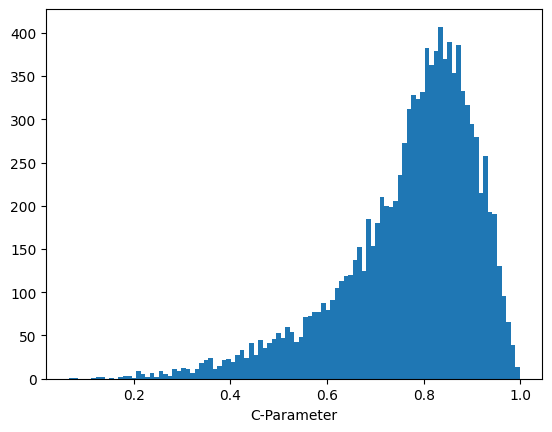

In [263]:
plt.hist(C,bins=100);
plt.xlabel("C-Parameter")

0.49912856022545554 0.9879928632871973


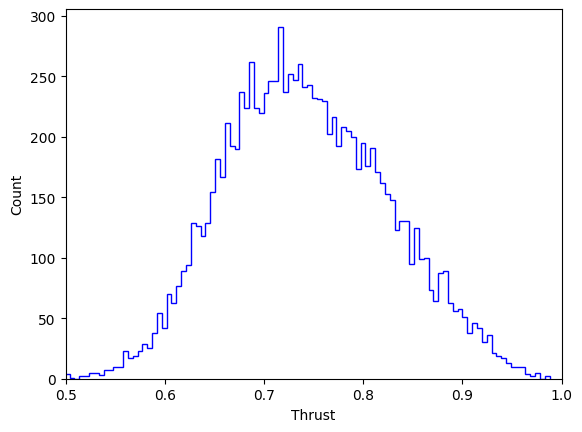

In [264]:
plt.hist(Thrust,bins=100,histtype='step',color='b');
plt.xlabel('Thrust')
plt.ylabel('Count')
print(min(Thrust), max(Thrust))
plt.xlim(0.5,1);
# plt.savefig('Paper/Plots/VegasMC_WIC_Thrust.png')
# plt.yscale('log')

10916
0.007639426818933265 0.9655992647362287


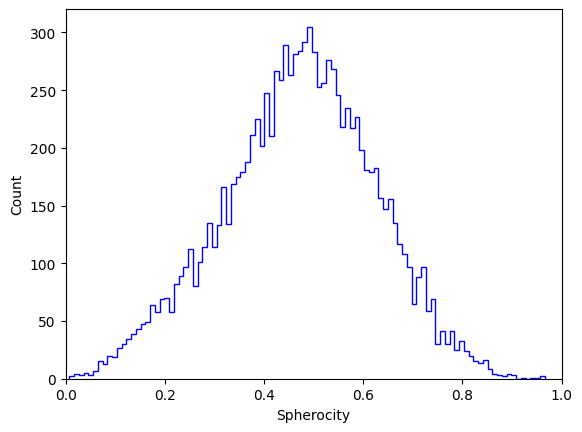

In [265]:
plt.hist(Spherocity,bins=100,histtype='step',color='b');
plt.xlim(0,1);
plt.ylabel('Count')
print(len(Spherocity))
print(min(Spherocity), max(Spherocity))
plt.xlabel("Spherocity");
# plt.savefig('Paper/Plots/VegasMC_WIC_Spherocity.png')

# Kinematics

10916 10858 8554 2332 161
10916 10875 8463 2300 153


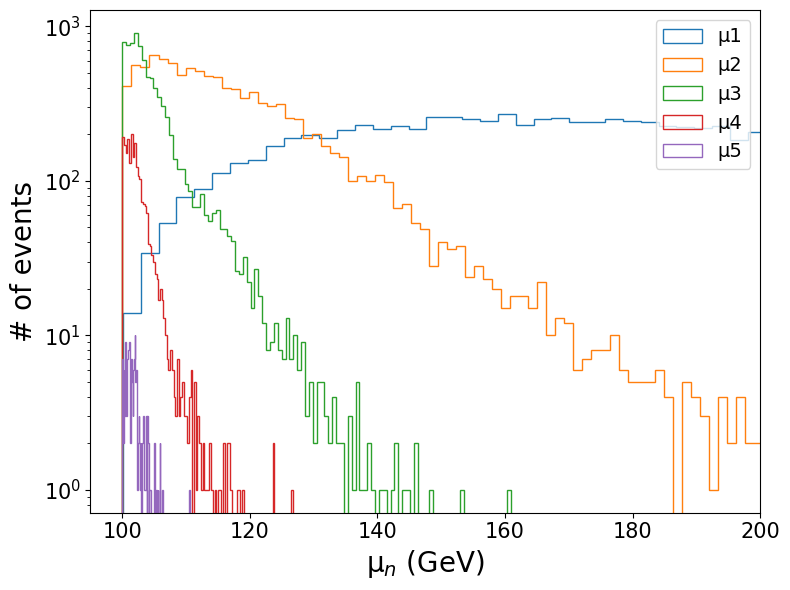

In [266]:
plt.figure(figsize=(8, 6))
plt.hist(μ1s, bins=100, histtype='step');
plt.hist(μ2s, bins=100, histtype='step');
plt.hist(μ3s, bins=100, histtype='step');
plt.hist(μ4s, bins=100, histtype='step');
plt.hist(μ5s, bins=100, histtype='step');
plt.xlim(95,200)
print(len(μ1s), len(μ2s), len(μ3s), len(μ4s), len(μ5s))
print(len(μ1ps), len(μ2ps), len(μ3ps), len(μ4ps), len(μ5ps))
# plt.hist(μ1ps, bins=100, histtype='step', color='k', alpha=0.3);
# plt.hist(μ2ps, bins=100, histtype='step', color='k', alpha=0.3);
# plt.hist(μ3ps, bins=100, histtype='step', color='k', alpha=0.3);
# plt.hist(μ4ps, bins=100, histtype='step', color='k', alpha=0.3);
# plt.hist(μ5ps, bins=100, histtype='step', color='k', alpha=0.3);
plt.legend(['μ1', 'μ2','μ3', 'μ4','μ5'], fontsize=14, loc="upper right");
plt.yscale('log')
plt.ylabel('# of events',size=20)
plt.xlabel('μ$_{n}$ (GeV)', size=20)
plt.tick_params(labelsize=15);
plt.tight_layout()
# plt.savefig('Paper/Plots/VegasMC_WIC_MassDistributions.png')

10916 10858 8554 2332 161
10916 10875 8463 2300 153


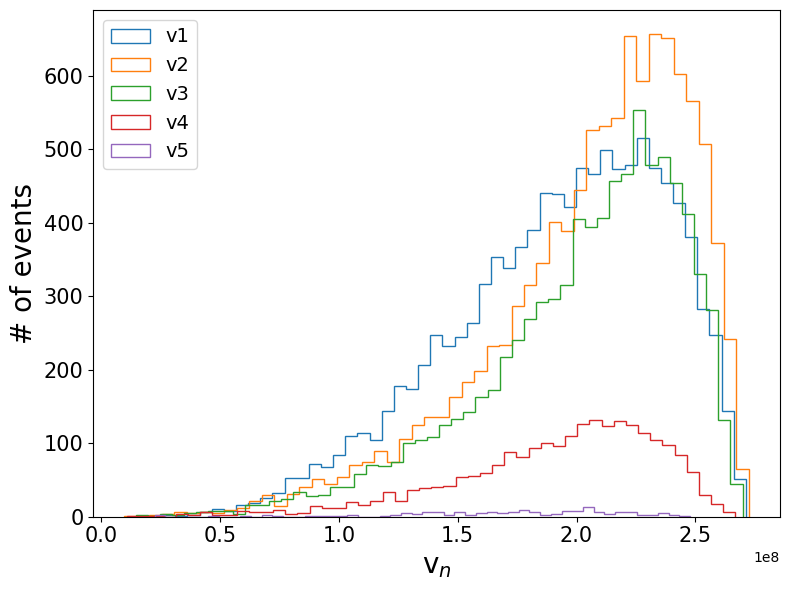

In [267]:
plt.figure(figsize=(8, 6))
plt.hist(v1s, bins=50, histtype='step');
plt.hist(v2s, bins=50, histtype='step');
plt.hist(v3s, bins=50, histtype='step');
plt.hist(v4s, bins=50, histtype='step');
plt.hist(v5s, bins=50, histtype='step');
# plt.xlim(95,150)
print(len(v1s), len(v2s), len(v3s), len(v4s), len(v5s))
print(len(v1ps), len(v2ps), len(v3ps), len(v4ps), len(v5ps))
# plt.hist(v1ps, bins=50, histtype='step', color='k', alpha=0.3);
# plt.hist(v2ps, bins=50, histtype='step', color='k', alpha=0.3);
# plt.hist(v3ps, bins=50, histtype='step', color='k', alpha=0.3);
# plt.hist(v4ps, bins=50, histtype='step', color='k', alpha=0.3);
# plt.hist(v5ps, bins=50, histtype='step', color='k', alpha=0.3);
plt.legend(['v1', 'v2', 'v3', 'v4', 'v5'], fontsize=14, loc="upper left");
plt.ylabel('# of events',size=20)
plt.xlabel('v$_{n}$', size=20)
plt.tick_params(labelsize=15);
plt.tight_layout()
# plt.savefig('Paper/Plots/VegasMC_WIC_VelocityDistributions.png')
# plt.yscale('log')

In [268]:
## Cut displaced vertices 
d1scut=np.array(d1s)[(0.001 < np.array(d1s))]
d2scut=np.array(d2s)[(0.001 < np.array(d2s))]
d3scut=np.array(d3s)[(0.001 < np.array(d3s))]
d4scut=np.array(d4s)[(0.001 < np.array(d4s))]
d5scut=np.array(d5s)[(0.001 < np.array(d5s))]
print(len(d1s),len(d1scut))
print(len(d2s),len(d2scut))
print(len(d3s),len(d3scut))
print(len(d4s),len(d4scut))
print(len(d5s),len(d5scut))

10858 133
8554 2132
2332 1399
161 125
2 2


10858 8554 2332 161 2


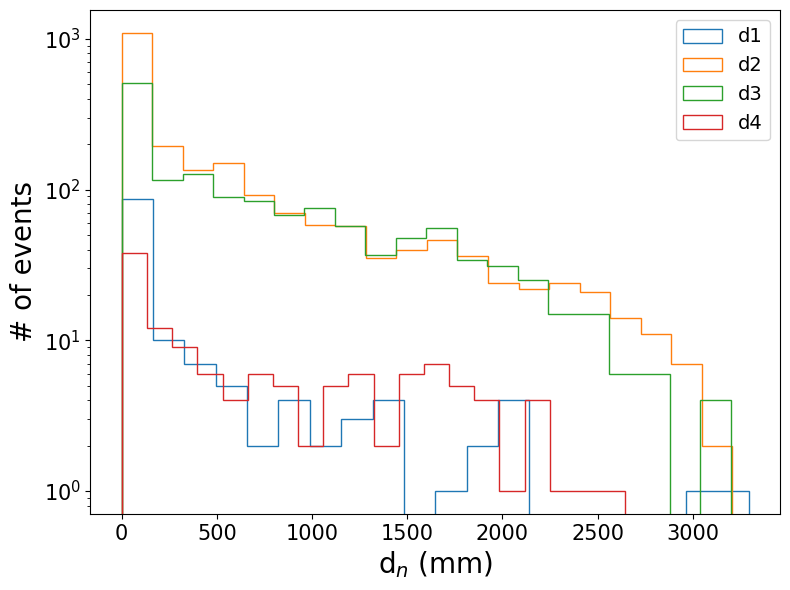

In [269]:
plt.figure(figsize=(8, 6))
normalized=False
plt.hist(np.array(d1scut)*10**(3), bins=20, histtype='step',density=normalized);
plt.hist(np.array(d2scut)*10**(3), bins=20, histtype='step',density=normalized);
plt.hist(np.array(d3scut)*10**(3), bins=20, histtype='step',density=normalized);
plt.hist(np.array(d4scut)*10**(3), bins=20, histtype='step',density=normalized);
# plt.hist(d5scut*10**(3), bins=50, histtype='step',density=True);
# plt.xlim(95,150)
print(len(d1s), len(d2s), len(d3s), len(d4s), len(d5s))
plt.legend(['d1', 'd2', 'd3', 'd4', 'd5'], fontsize=14, loc="upper right");
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('# of events',size=20)
plt.xlabel('d$_{n}$ (mm)', size=20)
# plt.xlim(0,650)
plt.tick_params(labelsize=15);
plt.tight_layout()
# plt.savefig('Paper/Plots/VegasMC_WIC_DisplacedVertexDistributions.png')

10858 8554 2332 161 2


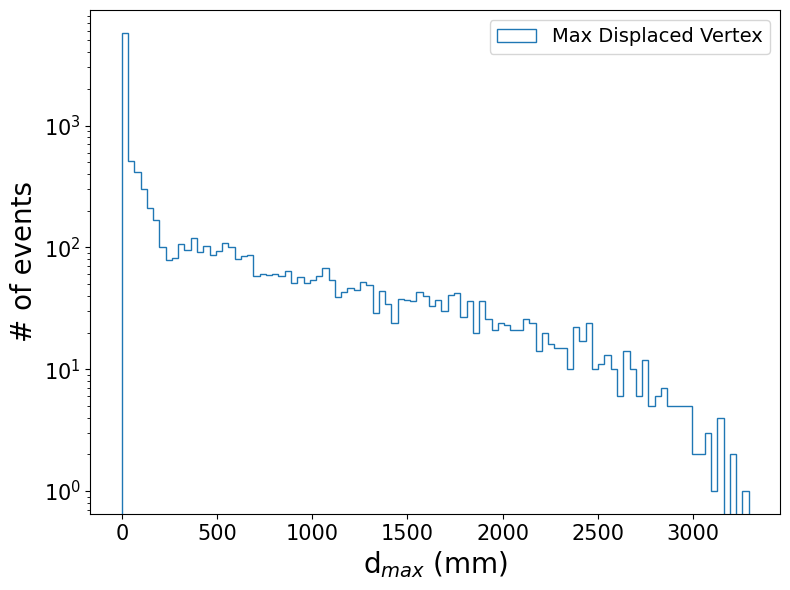

In [270]:
plt.figure(figsize=(8, 6))
normalized=False
plt.hist(np.array(max_ds)*10**(3), bins=100, histtype='step',density=normalized);
print(len(d1s), len(d2s), len(d3s), len(d4s), len(d5s))
plt.legend(['Max Displaced Vertex'], fontsize=14, loc="upper right");
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('# of events',size=20)
plt.xlabel('d$_{max}$ (mm)', size=20)
# plt.xlim(0,5000)
plt.tick_params(labelsize=15);
plt.tight_layout()
# plt.savefig('Paper/Plots/VegasMC_WIC_MaxDisplacedVertexDistribution.png')

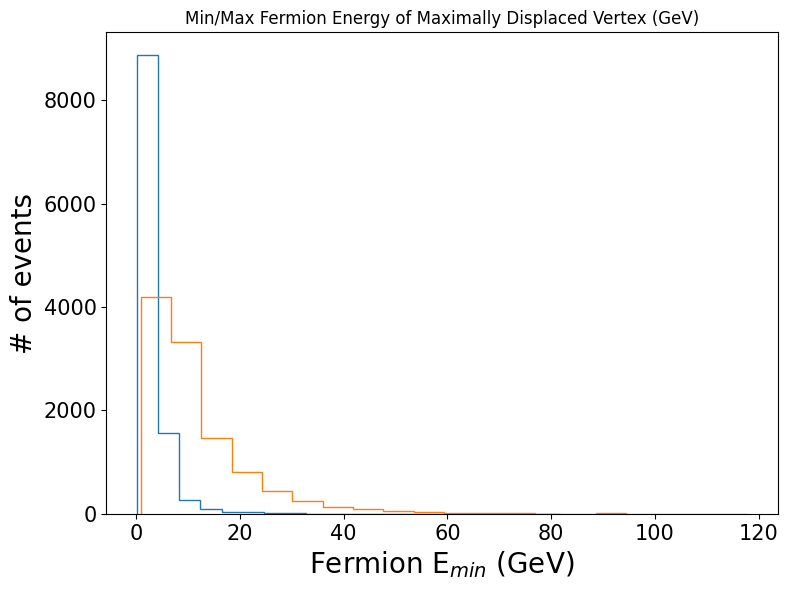

In [271]:
plt.figure(figsize=(8, 6))
normalized=False
plt.hist(minFermionE, bins=20, histtype='step',density=normalized);
plt.hist(maxFermionE, bins=20, histtype='step',density=normalized);
# plt.hist(ProdFermionE, bins=1000, histtype='step',density=normalized);
plt.title('Min/Max Fermion Energy of Maximally Displaced Vertex (GeV)')
# plt.legend(['Min Fermion Energy of Maximally Displaced Vertex (GeV)'], fontsize=14, loc="upper right");
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel('# of events',size=20)
plt.xlabel('Fermion E$_{min}$ (GeV)', size=20)
# plt.xlim(10**(0),10**(3))
plt.tick_params(labelsize=15);
plt.tight_layout()
# plt.savefig('Paper/Plots/VegasMC_WIC_MinFermionEofMaxV.png')

In [272]:
## Cut on Energy, Vertex ## 
max_ds_mm = np.array(max_ds)*10**(3)
minFermionE = np.array(minFermionE)
maxFermionE = np.array(maxFermionE)

cutE = [0] * len(minFermionE)
cutV = [1] * len(max_ds_mm)

booleansEmax = maxFermionE > cutE
booleansEmin = minFermionE > cutE
booleansV = max_ds_mm > cutV
booleansUpperE = minFermionE < [200]*len(minFermionE)
booleansUpperV = max_ds_mm < [5000]*len(max_ds_mm)

booleans = booleansEmax*booleansEmin*booleansV*booleansUpperV*booleansUpperE

maxFermionE_cut = maxFermionE[booleans]
minFermionE_cut = minFermionE[booleans]
max_ds_mm_cut = max_ds_mm[booleans]
print(np.shape(minFermionE), np.shape(maxFermionE), np.shape(max_ds_mm))
print(np.shape(minFermionE_cut), np.shape(maxFermionE_cut), np.shape(max_ds_mm_cut))

(10916,) (10916,) (10916,)
(6223,) (6223,) (6223,)


Text(0, 0.5, ' Min Energy of Corresopnding Fermion Pair (GeV)')

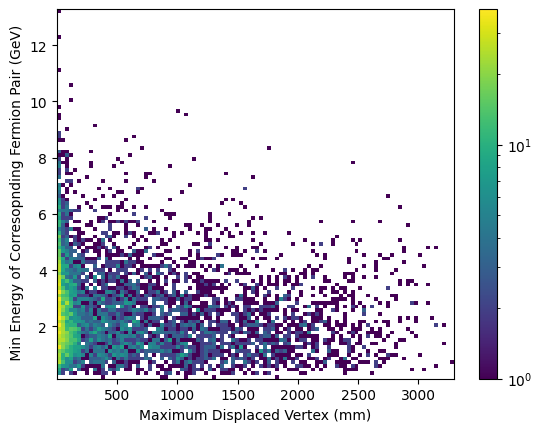

In [273]:
fig, ax = plt.subplots()
# ax.hist2d([120]*5, [1,2,3,4,5], bins=1000
#               ,norm=mpl.colors.LogNorm(), color='r'
#              );
pMin = ax.hist2d(max_ds_mm_cut, minFermionE_cut, bins=100
              ,norm=mpl.colors.LogNorm()
             );
fig.colorbar(pMin[3], ax=ax)
# plt.xlim(1,500)
# plt.ylim(0.01,20)
plt.xlabel('Maximum Displaced Vertex (mm)')
plt.ylabel(' Min Energy of Corresopnding Fermion Pair (GeV)')
# plt.savefig('Paper/Plots/VegasMC_WIC_DisVer_FermionE_1mmCut.png')
# plt.yscale('log')
# plt.xscale('log')

10858 8514 2323 155
10875 8510 2314 153


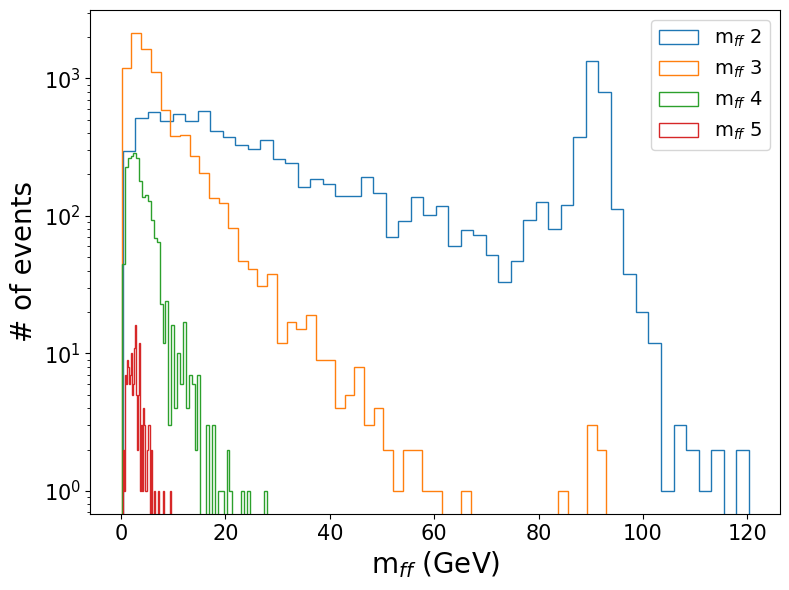

In [231]:
plt.figure(figsize=(8, 6))
print(len(Mff2), len(Mff3), len(Mff4), len(Mff5))
print(len(Mff2p), len(Mff3p), len(Mff4p), len(Mff5p))
plt.hist(Mff2, bins=50, histtype='step', alpha=1);
plt.hist(Mff3, bins=50, histtype='step', alpha=1);
plt.hist(Mff4, bins=50, histtype='step', alpha=1);
plt.hist(Mff5, bins=50, histtype='step', alpha=1);
# plt.hist(Mff2p, bins=50, histtype='step', color='gray', alpha=0.3);
# plt.hist(Mff3p, bins=50, histtype='step', color='gray', alpha=0.3);
# plt.hist(Mff4p, bins=50, histtype='step', color='gray', alpha=0.3);
# plt.hist(Mff5p, bins=50, histtype='step', color='gray', alpha=0.3);
plt.legend(['m$_{ff}$ 2', 'm$_{ff}$ 3', 'm$_{ff}$ 4', 'm$_{ff}$ 5'], fontsize=14, loc="upper right");
plt.yscale('log')
plt.ylabel('# of events',size=20)
plt.xlabel('m$_{ff}$ (GeV)', size=20)
plt.tick_params(labelsize=15);
plt.tight_layout()
# plt.savefig('Paper/Plots/VegasMC_WIC_MffDistributions.png')

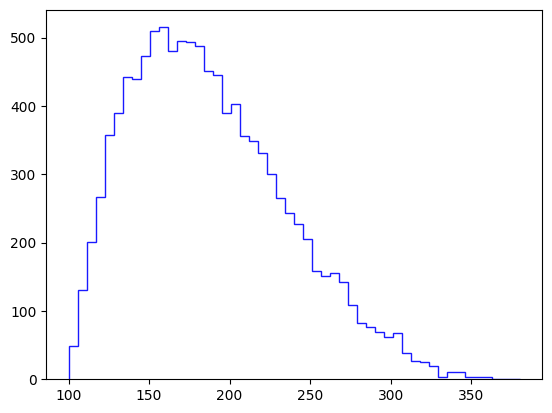

In [233]:
## Total 3-body Invariant Mass (Sanity Check)
plt.hist(Total_InvMass, bins=50, histtype='step', color='blue', alpha=0.9);
plt.hist(Total_InvMass_prime, bins=50, histtype='step', color='gray', alpha=0.);

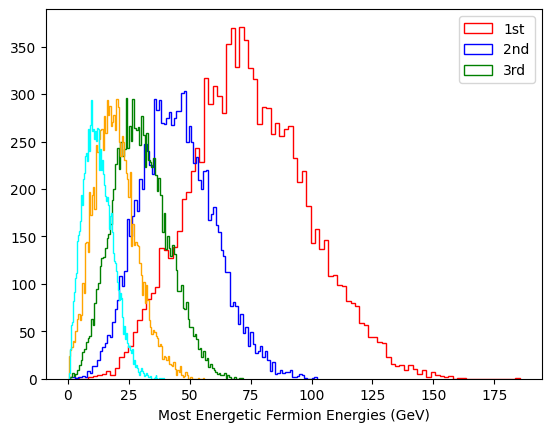

In [234]:
plt.hist(max1_fermion_energies, bins=100, histtype='step', color='red');
plt.hist(max2_fermion_energies, bins=100, histtype='step', color='blue');
plt.hist(max3_fermion_energies, bins=100, histtype='step', color='green');
plt.hist(max4_fermion_energies, bins=100, histtype='step', color='orange');
plt.hist(max5_fermion_energies, bins=100, histtype='step', color='cyan');
plt.xlabel('Most Energetic Fermion Energies (GeV)')
plt.legend(['1st', '2nd', '3rd'])
# plt.savefig('VegasMC_WIC_FermionEnergies.png')

(0.0, 20.0)

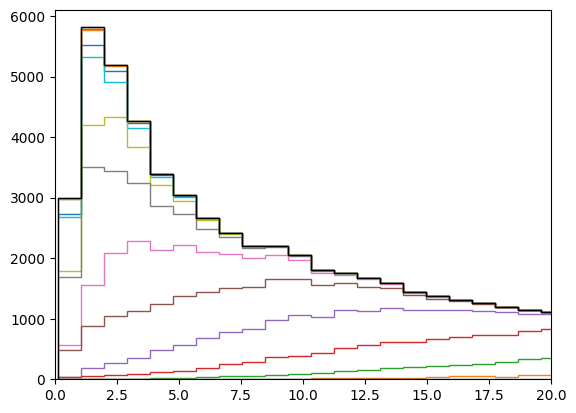

In [235]:
plt.hist([max1_fermion_energies, max2_fermion_energies, 
          max3_fermion_energies, max4_fermion_energies, 
          max5_fermion_energies, max6_fermion_energies, 
          max7_fermion_energies, max8_fermion_energies,
          max9_fermion_energies, max10_fermion_energies,
          max11_fermion_energies, max12_fermion_energies,
          max13_fermion_energies, max14_fermion_energies], bins=200, histtype='step', stacked=True);
# plt.yscale('log')
plt.hist(fermion_energies, bins=200, histtype='step', color='k')
plt.xlim(0,20)

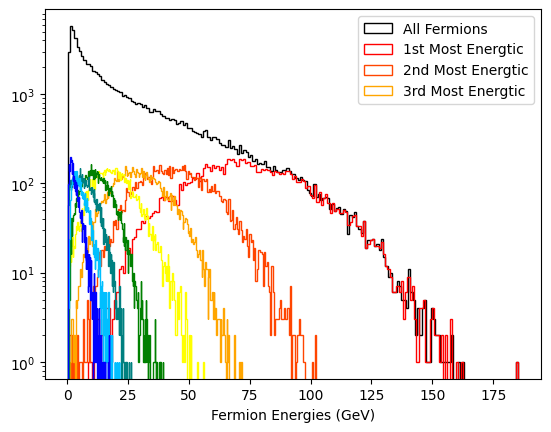

In [236]:
plt.hist(fermion_energies, bins=200, histtype='step', color='black');
plt.hist(max1_fermion_energies, bins=200, histtype='step', color='red');
plt.hist(max2_fermion_energies, bins=200, histtype='step', color='orangered');
plt.hist(max3_fermion_energies, bins=200, histtype='step', color='orange');
plt.hist(max4_fermion_energies, bins=200, histtype='step', color='yellow');
plt.hist(max5_fermion_energies, bins=200, histtype='step', color='green');
plt.hist(max6_fermion_energies, bins=200, histtype='step', color='teal');
plt.hist(max7_fermion_energies, bins=200, histtype='step', color='deepskyblue');
plt.hist(max8_fermion_energies, bins=200, histtype='step', color='blue');
# plt.hist(max9_fermion_energies, bins=200, histtype='step', color='magenta');
# plt.hist(max10_fermion_energies, bins=200, histtype='step', color='indigo');
# plt.hist(max11_fermion_energies, bins=200, histtype='step', color='gray');
plt.xlabel('Fermion Energies (GeV)')
plt.yscale('log')
plt.legend(['All Fermions', '1st Most Energtic', '2nd Most Energtic', '3rd Most Energtic'],
           fontsize=10, loc="upper right");
# plt.xscale('log')
# plt.savefig('Paper/Plots/VegasMC_WIC_FermionEnergies.png')

Text(0.5, 0, 'MET (GeV)')

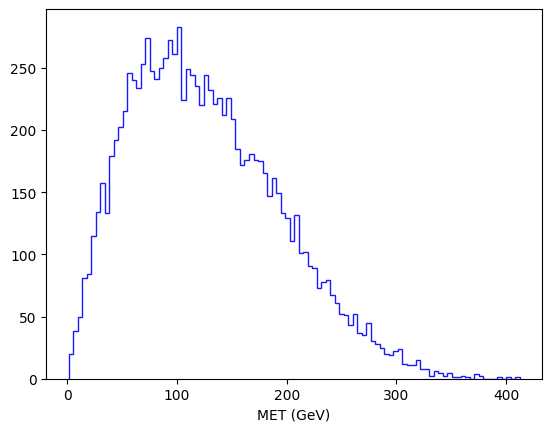

In [238]:
## Missing Energy
plt.hist(MET, bins=100, histtype='step', color='blue', alpha=0.9);
plt.xlabel('MET (GeV)')
# plt.savefig('Paper/Plots/VegasMC_WIC_MET.png')

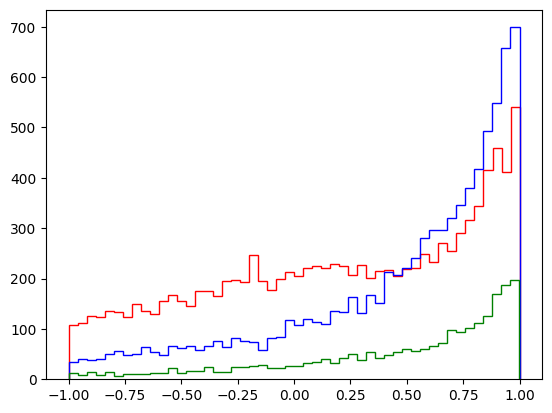

In [239]:
# Angle between fermion pairs
plt.hist(θff2, bins=50, histtype='step', color='red',density=False);
plt.hist(θff3, bins=50, histtype='step', color='blue',density=False);
plt.hist(θff4, bins=50, histtype='step', color='green',density=False);

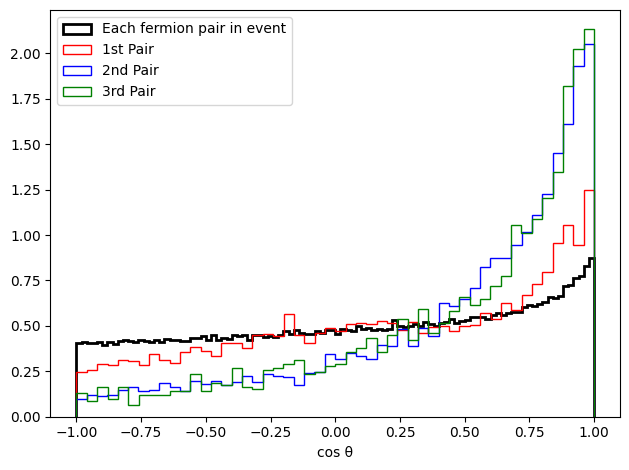

In [240]:
# Angles between all fermion pairs in each event
plt.hist(θffij, bins=100, histtype='step', color='black',density=True, linewidth=2);
# Angle between fermion pairs
plt.hist(θff2, bins=50, histtype='step', color='red',density=True);
plt.hist(θff3, bins=50, histtype='step', color='blue',density=True);
plt.hist(θff4, bins=50, histtype='step', color='green',density=True);
plt.legend(['Each fermion pair in event','1st Pair', '2nd Pair','3rd Pair'],loc='upper left')
plt.xlabel('cos θ')
plt.tight_layout()
# plt.savefig('Paper/Plots/VegasMC_WIC_FermionAngles.png')

Text(0.5, 0, 'ΔR')

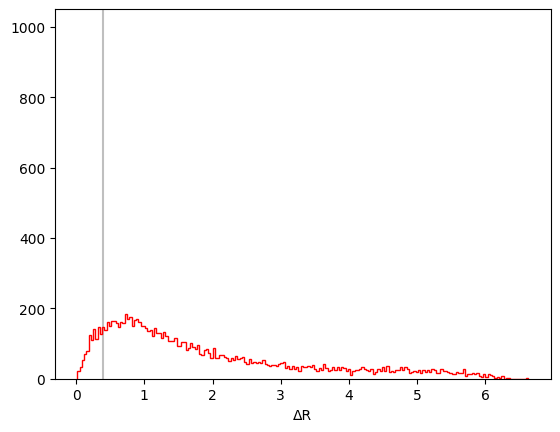

In [241]:
# Delta R
plt.hist(ΔR, bins=200, histtype='step', color='red',density=False);
plt.scatter(0.4,1000,marker='|',s=500000, color='gray',alpha=0.5)
plt.xlabel('ΔR')
# plt.yscale('log')
# plt.savefig('Paper/Plots/VegasMC_WIC_DeltaR.png')

# Multiplicities

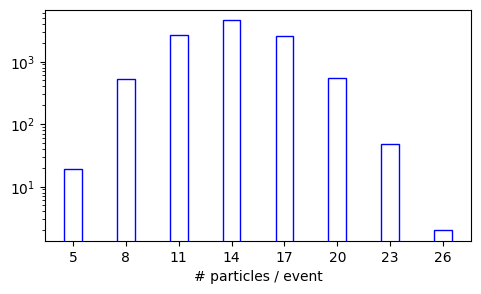

In [242]:
matplotlib.rc_file_defaults()
fig, ax = plt.subplots(1, 1, figsize = (5.5,3))
# Bar Plot
labels, counts = np.unique(multiplicities, return_counts=True)
plt.bar(labels, counts, align='center', width=1, color='white', edgecolor='b')
plt.gca().set_xticks(labels)
plt.xlabel('# particles / event');

plt.yscale('log')

[9417 1411   86    2]
[9449 1378   85    4]
[9439 1389   84    4]


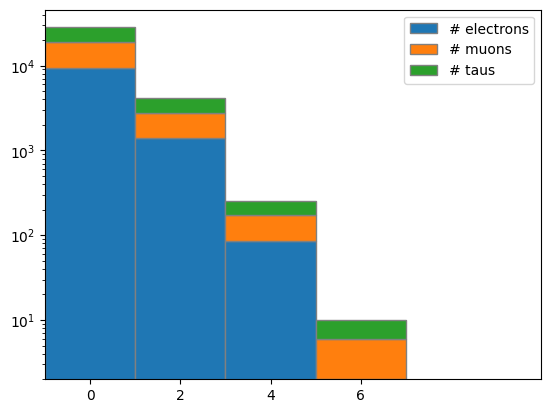

In [243]:
## Electron, Muon, & Tau multiplicities
## (have to adjust 'counts' array if they're not the same length)
labels, e_counts = np.unique(electrons, return_counts=True)
labels, mu_counts = np.unique(muons, return_counts=True)
labels, tau_counts = np.unique(taus, return_counts=True)

print(e_counts)
print(mu_counts)
print(tau_counts)

fig, ax = plt.subplots()
ax.bar(labels, e_counts, align='center', width=2, edgecolor='gray');
ax.bar(labels, mu_counts, align='center', width=2, edgecolor='gray', bottom=e_counts);
ax.bar(labels, tau_counts, align='center', width=2, edgecolor='gray', bottom=mu_counts+e_counts);

plt.gca().set_xticks(labels);
# (ns, bins, patches) = plt.hist([electrons, muons, taus], bins=4, 
#                                histtype='bar',stacked=True, edgecolor='gray');
ax.legend(['# electrons', '# muons', '# taus'])
plt.xlim(-1,10)
# plt.xticks([0,2,4,6])
plt.yscale('log')

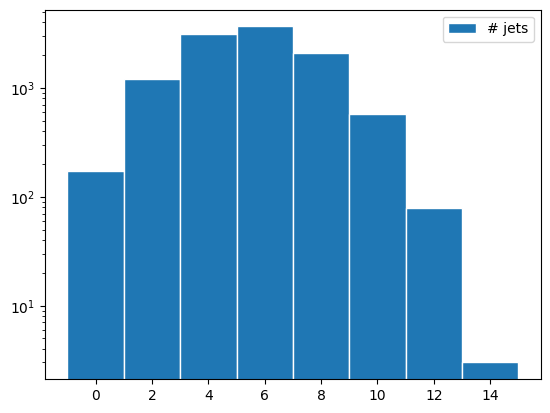

In [244]:
## No. of Jets
labels, counts = np.unique(jets, return_counts=True)
plt.bar(labels, counts, align='center', width=2, edgecolor='white');
plt.gca().set_xticks(labels);
plt.legend(['# jets'])
plt.yscale('log')

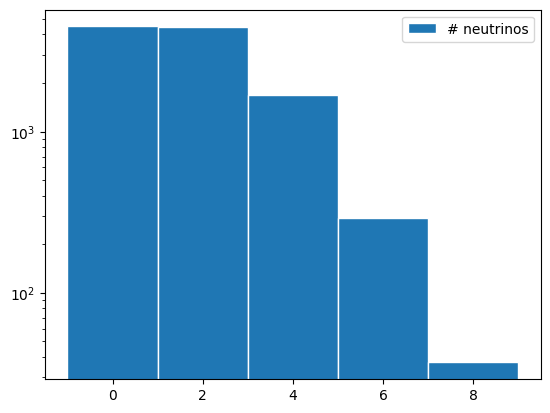

In [245]:
# No. of Neutrinos
labels, nu_counts = np.unique(Neutrinos, return_counts=True)
plt.bar(labels, nu_counts, align='center', width=2, edgecolor='white');
plt.gca().set_xticks(labels);
plt.legend(['# neutrinos'])
plt.yscale('log')

Text(0.5, 0, 'Number of Fermions')

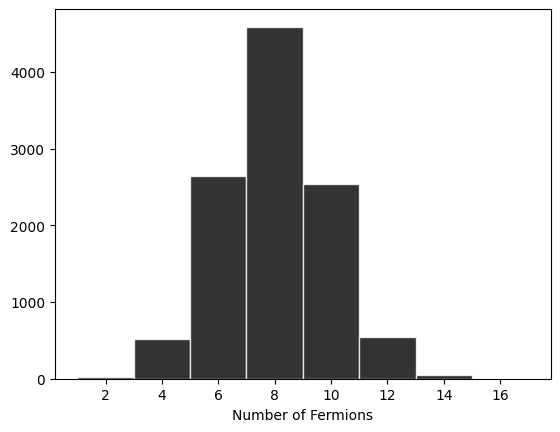

In [246]:
## No. of Fermions
labels, obs_counts = np.unique(obs_mult, return_counts=True)
plt.bar(labels, obs_counts, align='center', width=2, edgecolor='white',color='k',alpha=0.8);
plt.gca().set_xticks(labels);
plt.xlabel('Number of Fermions')
# plt.savefig('Paper/Plots/VegasMC_WIC_FermionMult.png')
# plt.yscale('log')